<a href="https://colab.research.google.com/github/JonatasLemos/DataAnalysisProjects/blob/main/closestCapitalAnalysis/ClosestCapitalPopulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Population Analysis - Influence Zone - Brazilian Capitals

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Cleaning DF

In [24]:
path_start = f"/content/drive/MyDrive/Colab Data/"
distance_cities_pop = pd.read_csv(f"{path_start}distance_cities.csv")
distance_cities_pop.drop(["NEAR_DIST","NEAR_FID"],axis=1,inplace=True)
distance_cities_pop.tail(3)

,NAME,STATE,CLOSEST_CAPITAL,CLOSEST_CAPITAL_STATE
5557,Zacarias/SP,SP,São Paulo/SP,SP
5558,Zé Doca/MA,MA,São Luís/MA,MA
5559,Zortéa/SC,SC,Porto Alegre/RS,RS


In [4]:
population = pd.read_excel(f"{path_start}output_distance.xlsx")
population.head()

,NAME,POPULAÇÃO ESTIMADA,STATE
0,Aracaju/SE,632744,SE
1,Belém/PA,1439561,PA
2,Belo Horizonte/MG,2502557,MG
3,Boa Vista/RR,320714,RR
4,Brasília/DF,2914830,DF


In [5]:
population['POPULAÇÃO ESTIMADA'].replace("41.487(*)","41487",inplace=True)
population["POPULAÇÃO ESTIMADA"] = population["POPULAÇÃO ESTIMADA"].astype(int)
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5560 entries, 0 to 5559
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   NAME                5560 non-null   object
 1   POPULAÇÃO ESTIMADA  5560 non-null   int64 
 2   STATE               5560 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.4+ KB


In [6]:
population.drop(["STATE"],axis=1,inplace=True)
distance_cities_pop = distance_cities_pop.merge(population)
distance_cities_pop.tail()

,NAME,STATE,CLOSEST_CAPITAL,CLOSEST_CAPITAL_STATE,POPULAÇÃO ESTIMADA
5555,Xique-Xique/BA,BA,Salvador/BA,BA,48316
5556,Zabelê/PB,PB,Maceió/AL,AL,2208
5557,Zacarias/SP,SP,São Paulo/SP,SP,2574
5558,Zé Doca/MA,MA,São Luís/MA,MA,50507
5559,Zortéa/SC,SC,Porto Alegre/RS,RS,3227


In [7]:
distance_cities_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5560 entries, 0 to 5559
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   NAME                   5560 non-null   object
 1   STATE                  5560 non-null   object
 2   CLOSEST_CAPITAL        5560 non-null   object
 3   CLOSEST_CAPITAL_STATE  5560 non-null   object
 4   POPULAÇÃO ESTIMADA     5560 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 260.6+ KB


## Grouping population by state and closest capital

In [8]:
grouped_states = distance_cities_pop.groupby(["STATE","CLOSEST_CAPITAL"])["POPULAÇÃO ESTIMADA"].sum().to_frame()
grouped_states = grouped_states.sort_values('POPULAÇÃO ESTIMADA', ascending=False).sort_index(level='STATE', sort_remaining=False)
grouped_states.to_csv("grouped_pop.csv")
grouped_states.head()

POPULAÇÃO ESTIMADA
STATE CLOSEST_CAPITAL                    
AC    Rio Branco/AC                803513
AL    Maceió/AL                   2782411
      Aracaju/SE                   558521
AM    Manaus/AM                   3322582
      Rio Branco/AC                346268

In [9]:
nationwide_influenced_pop = distance_cities_pop.groupby(["CLOSEST_CAPITAL"])["POPULAÇÃO ESTIMADA"].agg("sum")
nationwide_influenced_pop.sort_values(ascending=False).head()

CLOSEST_CAPITAL
São Paulo/SP         42127566
Rio de Janeiro/RJ    17393326
Curitiba/PR          13425941
Belo Horizonte/MG    13324194
Salvador/BA          12629410
Name: POPULAÇÃO ESTIMADA, dtype: int64

In [10]:
selection = distance_cities_pop["STATE"]==distance_cities_pop["CLOSEST_CAPITAL_STATE"]
statewide_pop = distance_cities_pop[selection]

In [11]:
statewide_influenced_pop = statewide_pop.groupby(["CLOSEST_CAPITAL"])["POPULAÇÃO ESTIMADA"].agg("sum")
statewide_influenced_pop.sort_values(ascending=False).head()

CLOSEST_CAPITAL
São Paulo/SP         40394666
Rio de Janeiro/RJ    15770090
Belo Horizonte/MG    13320597
Salvador/BA          12383385
Porto Alegre/RS      11247972
Name: POPULAÇÃO ESTIMADA, dtype: int64

## Creating DF containing Nationwide Influence and Statewide Influence

In [12]:
df_series = pd.DataFrame({'NATIONWIDE_POP': nationwide_influenced_pop,'STATEWIDE_POP': statewide_influenced_pop})
df_series.reset_index(level=0, inplace=True)
df_series["STATE"] = df_series["CLOSEST_CAPITAL"].str.split("/").apply(lambda x:x[1])

In [13]:
state_pop = distance_cities_pop.groupby(["STATE"])["POPULAÇÃO ESTIMADA"].agg("sum")
df_states_pop = pd.DataFrame({'STATE_POPULATION':state_pop})
df_states_pop.reset_index(level=0, inplace=True)

In [14]:
df_series = df_series.merge(df_states_pop)
df_series.head()

,CLOSEST_CAPITAL,NATIONWIDE_POP,STATEWIDE_POP,STATE,STATE_POPULATION
0,Aracaju/SE,5085599,2242937,SE,2242937
1,Belo Horizonte/MG,13324194,13320597,MG,20869101
2,Belém/PA,6403637,5783048,PA,8191477
3,Boa Vista/RR,571163,505665,RR,505665
4,Brasília/DF,5721218,2914830,DF,2914830


In [15]:
df_series["STATE/NATION"] = np.round((df_series["STATEWIDE_POP"]/df_series["NATIONWIDE_POP"])*100,2)
df_series["STATEWIDE_INFLUENCE"] = np.round((df_series["STATEWIDE_POP"]/df_series["STATE_POPULATION"])*100,2)
total_pop_brazil = df_series["STATE_POPULATION"].sum()
df_series["NATIONWIDE_INFLUENCE"] = np.round((df_series["NATIONWIDE_POP"]/total_pop_brazil)*100,2)
df_series.drop(["STATE"],axis=1,inplace=True)
df_series.head()

,CLOSEST_CAPITAL,NATIONWIDE_POP,STATEWIDE_POP,STATE_POPULATION,STATE/NATION,STATEWIDE_INFLUENCE,NATIONWIDE_INFLUENCE
0,Aracaju/SE,5085599,2242937,2242937,44.10,100.00,2.49
1,Belo Horizonte/MG,13324194,13320597,20869101,99.97,63.83,6.52
2,Belém/PA,6403637,5783048,8191477,90.31,70.60,3.13
3,Boa Vista/RR,571163,505665,505665,88.53,100.00,0.28
4,Brasília/DF,5721218,2914830,2914830,50.95,100.00,2.80


In [16]:
select = df_series["STATEWIDE_INFLUENCE"] == 100.0
print("CAPITALS WITH STATEWIDE INFLUENCE OF 100%")
capitals_100 = df_series[select]["CLOSEST_CAPITAL"].to_frame()
capitals_100.rename(columns={"CLOSEST_CAPITAL":"CAPITAL"},inplace=True)
capitals_100.reset_index(inplace=True,drop=True)
capitals_100

CAPITALS WITH STATEWIDE INFLUENCE OF 100%


,CAPITAL
0,Aracaju/SE
1,Boa Vista/RR
2,Brasília/DF
3,Macapá/AP
4,Porto Alegre/RS
5,Rio Branco/AC
6,Vitória/ES


## PLOTING

In [17]:
title_font = 20
label_font = 14
plt.rcParams["figure.figsize"] = [9, 6]
def plot_bar(*args):
  plt.barh(args[0],args[1])
  plt.suptitle(args[-1],fontsize=title_font)
  plt.title(args[2],fontsize=label_font)
  plt.xlabel('% da população',fontsize=label_font)
  plt.ylabel('Capital',fontsize=label_font)
  plt.xticks(fontsize=label_font)
  plt.yticks(fontsize=label_font)
  plt.grid(lw="0.2")
  plt.show()

In [18]:
df_series.sort_values(by="STATEWIDE_INFLUENCE",inplace=True,ascending=False)
df_series_10 = df_series.head(10)
df_series.sort_values(by="STATEWIDE_INFLUENCE",inplace=True,ascending=False)
df_last_10 = df_series.tail(6)

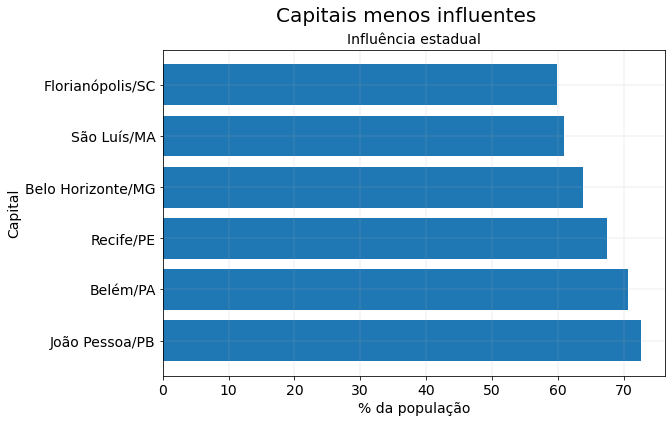

In [19]:
plot_bar(df_last_10["CLOSEST_CAPITAL"],df_last_10["STATEWIDE_INFLUENCE"],
         'Influência estadual',"Capitais menos influentes")

In [20]:
df_series.sort_values(by="STATE/NATION",inplace=True,ascending=True)
df_series_10 = df_series.tail(6)
df_series.sort_values(by="STATE/NATION",inplace=True,ascending=False)
df_last_10 = df_series.tail(6)

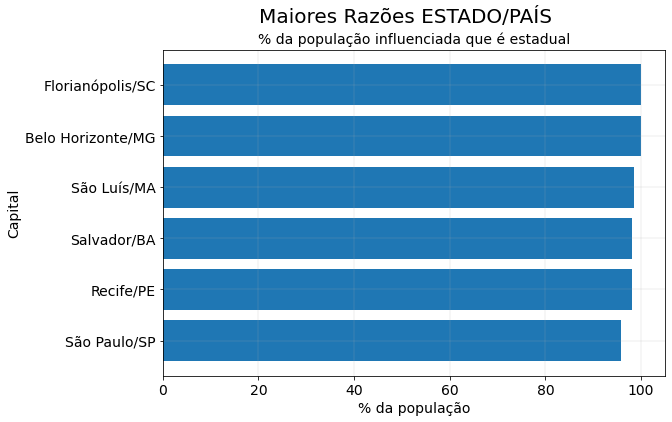

In [21]:
plot_bar(df_series_10["CLOSEST_CAPITAL"],df_series_10["STATE/NATION"],
         '% da população influenciada que é estadual','Maiores Razões ESTADO/PAÍS')

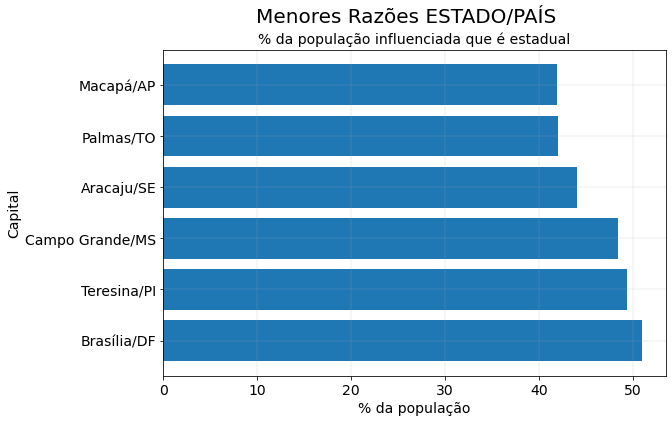

In [22]:
plot_bar(df_last_10["CLOSEST_CAPITAL"],df_last_10["STATE/NATION"],
         '% da população influenciada que é estadual','Menores Razões ESTADO/PAÍS')

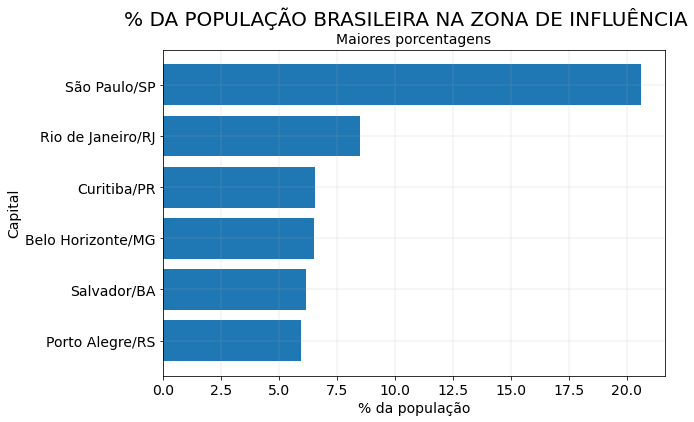

In [23]:
df_series.sort_values(by="NATIONWIDE_INFLUENCE",inplace=True,ascending=True)
df_series_10 = df_series.tail(6)
plot_bar(df_series_10["CLOSEST_CAPITAL"],df_series_10["NATIONWIDE_INFLUENCE"],
         'Maiores porcentagens','% DA POPULAÇÃO BRASILEIRA NA ZONA DE INFLUÊNCIA')